In [116]:
from decimal import Decimal, getcontext
import numpy as np
import math
import matplotlib.pyplot as plt

getcontext().prec = 1000

def gen_almost_one(size):
    if size < 2:
        raise ValueError("size must be at least 2 for gen_almost_one")
    big_val = np.random.uniform(0.9, 0.999)
    remain = 1.0 - big_val
    other = np.random.rand(size - 1)
    other_sum = np.sum(other)
    if other_sum > 0:
        other = other / other_sum * remain
    else:
        other = np.zeros(size - 1)
    eigs = np.concatenate(([big_val], other))
    eigs = np.sort(eigs)[::-1]
    decimal_eigs = [Decimal(str(eig)) for eig in eigs]
    return decimal_eigs

def gen_almost_same(size):
  return [1/Decimal(size) for _ in range(size)]

def gen_arithmetic(max_min_gap, size):
    if max_min_gap > 2 / size or max_min_gap > 2 - 2 / size:
        print("[gen_arithmetic] Error: Cannot satisfy the given max_min_gap.")
        return None
    eigs = np.linspace(1/size + max_min_gap/2, 1/size - max_min_gap/2, size)
    s = np.sum(eigs)
    if s == 0:
        return None
    eigs /= s
    decimal_eigs = [Decimal(str(eig)) for eig in eigs]

    return decimal_eigs

def gen_geometric(max_min_ratio, size):
    if max_min_ratio <= 1:
        print("[gen_geometric] Error: max_min_ratio must be > 1.")
        return None
    r = max_min_ratio ** (1 / (1 - size))
    numerator = (1 - r)
    denominator = (1 - r**size)
    if denominator == 0:
        return None
    a_1 = numerator / denominator
    a_size = numerator * (r**(size - 1)) / denominator
    eigs = np.geomspace(a_1, a_size, num=size)
    s = np.sum(eigs)
    if s == 0:
        return None
    eigs /= s
    decimal_eigs = [Decimal(str(eig)) for eig in eigs]

    return decimal_eigs

def newton_girard_predict(traces, k):
    r = len(traces)
    if k <= r:
        return traces[k-1]
    sums = [Decimal('0.0')]*(k+1)
    sums[0] = Decimal('1.0')
    for i in range(1, r+1):
        sums[i] = traces[i-1]

    a = [Decimal('0.0')]*(r+1)
    a[0] = Decimal('1.0')
    a[1] = sums[1]

    for i in range(2, r+1):
        temp = Decimal('0.0')
        for j in range(1, i+1):
            if j%2 == 0:
                temp += Decimal('-1.0') * a[i-j] * sums[j]
            else:
                temp += a[i-j] * sums[j]
        a[i] = temp / Decimal(i)

    for m in range(r+1, k+1):
        tmp = Decimal('0.0')
        for j in range(1, r+1):
            if j%2 == 0:
                tmp += Decimal('-1.0') * sums[m-j] * a[j]
            else:
                tmp += sums[m-j] * a[j]
        sums[m] = tmp

    return sums[k]

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


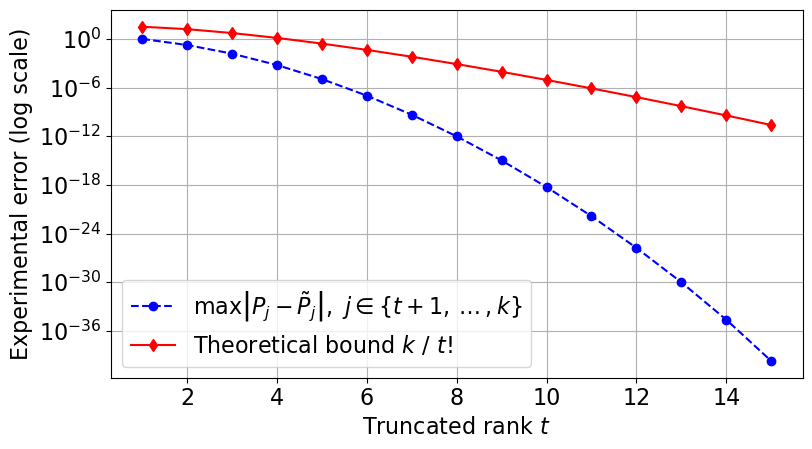

In [123]:
from tqdm import tqdm

def experimentA_band(r=16, k_A=16, N=10000):
    t_max = min(r, k_A)
    t_vals = range(1, t_max)  # 1..15
    min_errors = np.full((t_max-1,), np.inf)
    max_errors = np.zeros((t_max-1,))
    bounds = np.zeros((t_max-1,))
    factorials = [math.factorial(t) for t in t_vals]

    for trial in tqdm(range(N)):
        eigs = gen_geometric(2 ** 15, r)
        full_traces = []
        for i in range(1, r+1):
          temp = Decimal('0.0')
          for j in range(len(eigs)):
            temp += eigs[j] ** Decimal(i)
          full_traces.append(temp)

        P_k_full = newton_girard_predict(full_traces, k_A)
        for i, t in enumerate(t_vals):
            truncated_traces = full_traces[:t]
            err = 0
            for j in range(t+1, k_A+1):
              P_k_full = newton_girard_predict(full_traces, j)
              P_k_trunc = newton_girard_predict(truncated_traces, j)
              e = abs(P_k_full - P_k_trunc)
              if e > err:
                err = e
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err

    for i, t in enumerate(t_vals):
        bounds[i] = k_A / factorials[i]

    plt.figure(figsize=(8,4.5))
    # plt.fill_between(t_vals, min_errors, max_errors, color='blue', alpha=0.2)
    # plt.plot(t_vals, min_errors, 'b--', alpha=0.5, label=r"$\max\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, max_errors, 'bo--', alpha=1, label=r"$\max\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, bounds, 'rd-', label=r"Theoretical bound $k~/~t!$")
    plt.xlabel("Truncated rank $t$", fontsize=16)
    plt.ylabel("Experimental error (log scale)", fontsize=16)
    plt.yscale('log')
    # plt.title(f"Experiment A (band): r={r}, k={k_A}, N={N}")
    # plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.legend(fontsize=16, loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    # plt.title("Geometric Eigenvalues - Experiment 2", size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.savefig("result/geo_exp2.png", bbox_inches="tight", dpi=300)
    plt.show()

experimentA_band(r=16, k_A=32, N=1)

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


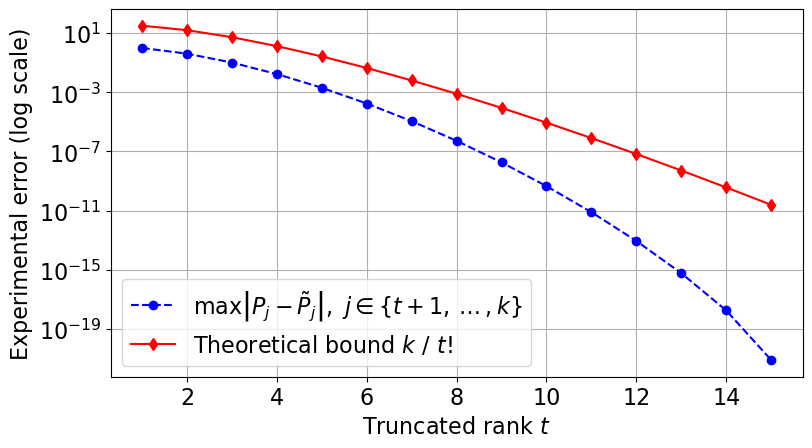

In [122]:
from tqdm import tqdm

def experimentA_band(r=16, k_A=16, N=10000):
    t_max = min(r, k_A)
    t_vals = range(1, t_max)
    min_errors = np.full((t_max-1,), np.inf)
    max_errors = np.zeros((t_max-1,))
    bounds = np.zeros((t_max-1,))
    factorials = [math.factorial(t) for t in t_vals]

    for trial in tqdm(range(N)):
        eigs = gen_arithmetic(0.124, r)
        full_traces = []
        for i in range(1, r+1):
          temp = Decimal('0.0')
          for j in range(len(eigs)):
            temp += eigs[j] ** Decimal(i)
          full_traces.append(temp)

        P_k_full = newton_girard_predict(full_traces, k_A)
        for i, t in enumerate(t_vals):
            truncated_traces = full_traces[:t]
            err = 0
            for j in range(t+1, k_A+1):
              P_k_full = newton_girard_predict(full_traces, j)
              P_k_trunc = newton_girard_predict(truncated_traces, j)
              e = abs(P_k_full - P_k_trunc)
              if e > err:
                err = e
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err

    for i, t in enumerate(t_vals):
        bounds[i] = k_A / factorials[i]

    plt.figure(figsize=(8,4.5))
    plt.plot(t_vals, max_errors, 'bo--', alpha=1, label=r"$\max\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, bounds, 'rd-', label=r"Theoretical bound $k~/~t!$")
    plt.xlabel("Truncated rank $t$", fontsize=16)
    plt.ylabel("Experimental error (log scale)", fontsize=16)
    plt.yscale('log')
    # plt.title(f"Experiment A (band): r={r}, k={k_A}, N={N}")
    # plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.legend(fontsize=16, loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    # plt.title("Arithmetic Eigenvalues - Experiment 2", size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.savefig("result/arith_exp2.png", bbox_inches="tight", dpi=300)
    plt.show()

experimentA_band(r=16, k_A=32, N=1)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


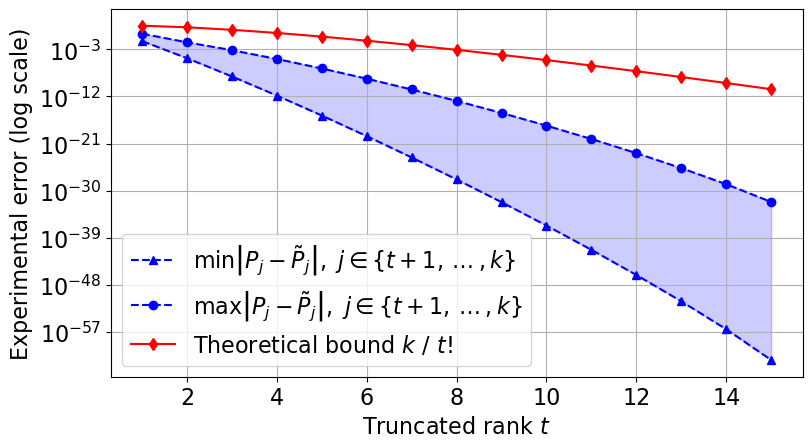

In [124]:
from tqdm import tqdm

def experimentA_band(r=16, k_A=16, N=10000):
    t_max = min(r, k_A)
    t_vals = range(1, t_max)  # 1..15
    min_errors = np.full((t_max-1,), np.inf)
    max_errors = np.zeros((t_max-1,))
    bounds = np.zeros((t_max-1,))
    factorials = [math.factorial(t) for t in t_vals]

    for trial in tqdm(range(N)):
        eigs = gen_almost_one(r)
        full_traces = []
        for i in range(1, r+1):
          temp = Decimal('0.0')
          for j in range(len(eigs)):
            temp += eigs[j] ** Decimal(i)
          full_traces.append(temp)

        P_k_full = newton_girard_predict(full_traces, k_A)

        for i, t in enumerate(t_vals):
            truncated_traces = full_traces[:t]
            err = 0
            for j in range(t+1, k_A+1):
              P_k_full = newton_girard_predict(full_traces, j)
              P_k_trunc = newton_girard_predict(truncated_traces, j)
              e = abs(P_k_full - P_k_trunc)
              if e > err:
                err = e
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err

    for i, t in enumerate(t_vals):
        bounds[i] = k_A / factorials[i]

    plt.figure(figsize=(8,4.5))
    plt.fill_between(t_vals, min_errors, max_errors, color='blue', alpha=0.2)
    plt.plot(t_vals, min_errors, 'b^--', alpha=1, label=r"$\min\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, max_errors, 'bo--', alpha=1, label=r"$\max\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, bounds, 'rd-', label=r"Theoretical bound $k~/~t!$")
    plt.xlabel("Truncated rank $t$", fontsize=16)
    plt.ylabel("Experimental error (log scale)", fontsize=16)
    plt.yscale('log')
    # plt.title(f"Experiment A (band): r={r}, k={k_A}, N={N}")
    # plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.legend(fontsize=16, loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    # plt.title("One Dominant Eigenvalue - Experiment 2", size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.savefig("result/dominant_exp2.png", bbox_inches="tight", dpi=300)
    plt.show()

experimentA_band(r=16, k_A=32, N=1000)

100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


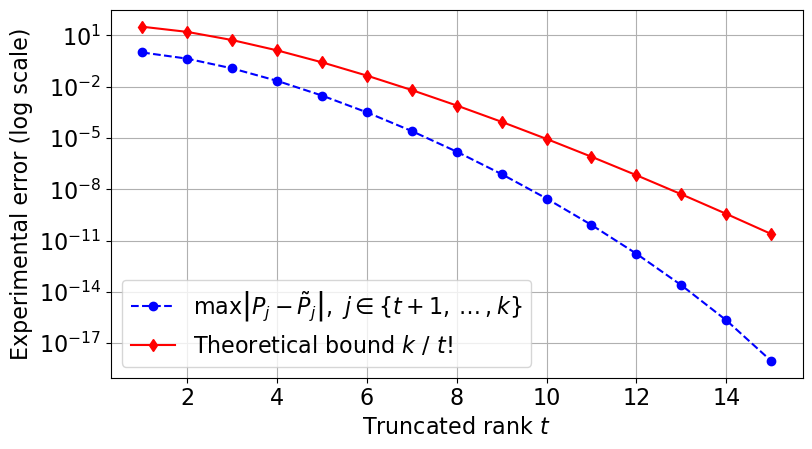

In [121]:
from tqdm import tqdm

def experimentA_band(r=16, k_A=16, N=10000):
    t_max = min(r, k_A)
    t_vals = range(1, t_max)
    min_errors = np.full((t_max-1,), np.inf)
    max_errors = np.zeros((t_max-1,))
    bounds = np.zeros((t_max-1,))
    factorials = [math.factorial(t) for t in t_vals]

    for trial in tqdm(range(N)):
        eigs = gen_arithmetic(0, r)
        full_traces = []
        for i in range(1, r+1):
          temp = Decimal('0.0')
          for j in range(len(eigs)):
            temp += eigs[j] ** Decimal(i)
          full_traces.append(temp)

        P_k_full = newton_girard_predict(full_traces, k_A)
        for i, t in enumerate(t_vals):
            truncated_traces = full_traces[:t]
            err = 0
            for j in range(t+1, k_A+1):
              P_k_full = newton_girard_predict(full_traces, j)
              P_k_trunc = newton_girard_predict(truncated_traces, j)
              e = abs(P_k_full - P_k_trunc)
              if e > err:
                err = e
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err

    for i, t in enumerate(t_vals):
        bounds[i] = k_A / factorials[i]

    plt.figure(figsize=(8,4.5))
    plt.plot(t_vals, max_errors, 'bo--', alpha=1, label=r"$\max\left|P_j - \tilde{P}_j\right|,~j\in\{t+1,\dots,k\}$")
    plt.plot(t_vals, bounds, 'rd-', label=r"Theoretical bound $k~/~t!$")
    plt.xlabel("Truncated rank $t$", fontsize=16)
    plt.ylabel("Experimental error (log scale)", fontsize=16)
    plt.yscale('log')
    # plt.title(f"Experiment A (band): r={r}, k={k_A}, N={N}")
    # plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.legend(fontsize=16, loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    # plt.title("Identical Eigenvalues - Experiment 2", size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.savefig("result/id_exp2.png", bbox_inches="tight", dpi=300)
    plt.show()

experimentA_band(r=16, k_A=32, N=1)